In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.Nonly import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [3]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22, lgdFrameAlpha=0.0,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':lgdFrameAlpha}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M
color_gamma = 'tab:green'
color_CP0 = 'tab:red'
color_kbP = 'tab:orange'

# Discrete protein number selectivity

In [ ]:
GenParms = lambda KPP: GenParameters(
    numTargets=2, NP0=[2], KPP=KPP, KPN=[10], area3Dto1D=[10], lengthScale=2, 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6
)

In [ ]:
parms = GenParms(10.0**np.arange(0,7.01,0.25))

In [ ]:
def pFree_One(parm, V):
    # Assume there is only one protein
    KPS = parm['KPS']
    KPP = parm['KPP']
    KPN = parm['KPN']
    S = parm['CS0'] * V
    N = parm['CN0'] * V
    C0 = 0.6022
    gamma = parm['gamma']
    return 1 / (1 + KPS/V*S + KPN/V*N + gamma*KPS/V*KPN/V*S*N)

def partition_Two(parm, V, cluster:bool):
    # Assume there are two proteins
    KPS = parm['KPS']
    KPP = parm['KPP']
    KPN = parm['KPN']
    S = parm['CS0'] * V
    N = parm['CN0'] * V
    C0 = 0.6022
    gamma = parm['gamma']
    
    # relative probabilities
    # containing free monomers
    P_P = 1
    PS_P = 2*KPS/V*S
    PN_P = 2*KPN/V*N
    PSN_P = 2*gamma*(KPS/V)*(KPN/V) * S*N
    # monomer + monomer
    PS_PS = (KPS/V)**2 * S*(S-1)
    PN_PN = (KPN/V)**2 * N*(N-1)
    PS_PN = 2*(KPS/V)*(KPN/V) * S*N
    PSN_PS = 2*gamma*(KPS/V)**2*(KPN/V) * S*(S-1)*N
    PSN_PN = 2*gamma*(KPS/V)*(KPN/V)**2 * S*N*(N-1)
    PSN_PSN = (gamma*KPS/V*KPN/V)**2 * S*(S-1)*N*(N-1)
    # dimer, take Ptot = 2
    PP = 2*(KPP/V) * 2
    PPS = 2*(KPP/V)*2*(KPS/V) * 2*S
    PPN = 2*(KPP/V)*2*(KPN/V) * 2*N
    PPSN = 2*gamma*(KPP/V)*2*(KPS/V)*(KPN/V) * 2*S*N
    PSPN = 2*gamma*(KPP/V)*2*KPS/V*KPN/V * 2*S*N
    PNPN = 2*gamma*(KPP/V)*(KPN/V)**2 * 2*N*(N-1)
    PSPS = 2*(KPP/V)*2*(KPS/V)*(KPS*C0) * 2*S
    PSPSN = 2*gamma*(KPP/V)*2*(KPS/V)*(KPS*C0)*2*(KPN/V) * 2*S*N
    PNPSN = 2*gamma**2*(KPP/V)*2*(KPN/V)**2*2*(KPS/V) * 2*N*(N-1)*S
    PSNPSN = 2*gamma**2*(KPP/V)*2*(KPN/V)**2*(KPS/V)*(KPS*C0) * 2*N*(N-1)*S
    
    if cluster:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PSPS + PSPSN + PNPSN + PSNPSN)
    else:
        total = (1 + PS_P + PN_P + PSN_P) + \
                (PS_PS + PN_PN + PS_PN + PSN_PS + PSN_PN + PSN_PSN) + \
                (PP + PPS + PPN + PPSN + PSPN + PNPN + PNPSN)
        
    return total, (1 + PS_P + PN_P + PSN_P)

In [ ]:
def estimateSelectivity(parm, ftwo=1):
    '''fdimer: the time fraction of two proteins are in the same environment'''
    # only for 2 proteins in the whole system
    V = 2 / parm['CS0'].unique()
    # partition function for cluster
    Z_cluster, Z_free = partition_Two(parm, V, True)
    # partition function for separate
    Z_separate, Z_free = partition_Two(parm, V, False)
    # total Z for two
    Z_tot = Z_cluster + Z_separate
    # bound monomer number on each side
    boundP_mono = (1 - pFree_One(parm, V))*(1-ftwo)
    return ((Z_cluster-Z_free)/Z_tot*2*ftwo + boundP_mono) / ((Z_separate-Z_free)/Z_tot*2*ftwo + boundP_mono)

In [ ]:
# NERDSS results
slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]

In [ ]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
plt.errorbar(
    np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
    slcList_repeats_2pro[0], slcList_repeats_2pro[1], 
    ls='', color=colors[0], marker='.', #edgecolors='black', alpha=alphas[1], 
)

plt.plot(
    parms['KPP']*0.6022, estimateSelectivity(parms, 0.9), ls='-', 
    label='$N_P^{tot}$=%d'%2, lw=2, color=colors[0], #color='tab:orange', alpha=alphas[i], 
    zorder=1,
)


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# mean residence time phase diagram

In [179]:
def criticalRate_DNAclusTarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    KPSC0chiS = parm['KPS'].to_numpy()*0.6022*chiS
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    nu_add = onRate*KPSC0chiS*(1+chiN*gamma)**2
    return (nu+nu_add)/chiDNA**2

def criticalRate_DNAtarg(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    chiDNA = chiN + chiS + gamma*chiS*chiN
    onRate = (kbPS*chiS + kbPN*chiN)
    nu = (onRate*(2*gamma*chiN*chiS + gamma*chiN**2 + 2*(gamma*chiN)**2*chiS))
    return nu/chiDNA**2

def criticalRate_DNA(parm):
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return gamma*chiN*kbPN

In [180]:
parms = GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=np.logspace(0,3,100), 
    KPP=[1e3], kbPP_fixed=0.1,
)


[]

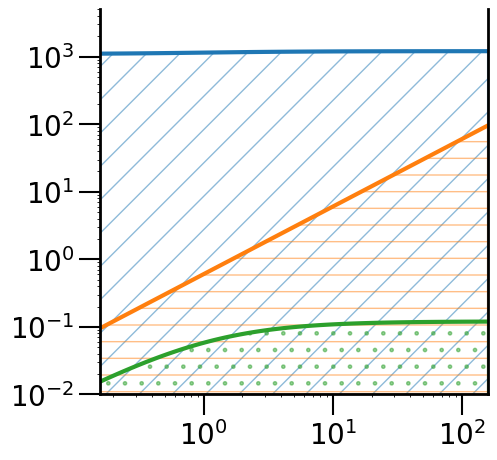

In [183]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.05,0.5], lgdFontSize=15, lgdHandleL=0.3, lgdFrameAlpha=0.7,
    lgdTitle='below $k^*$ of:', lgdTtlFontSize=15,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=2
)
plt.rcParams['lines.linewidth'] = 3
ax.spines['top'].set_linewidth(0)
ymin = 1e-2
gammaChiNkoff = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()

plt.plot(gammaChiNkoff, criticalRate_DNAclusTarg(parms), color='tab:blue')
plt.plot(gammaChiNkoff, criticalRate_DNAtarg(parms), color='tab:green')
plt.plot(gammaChiNkoff, criticalRate_DNA(parms), color='tab:orange')

plt.fill_between(
    gammaChiNkoff, ymin, criticalRate_DNAclusTarg(parms), label='DNA+clusTarg',
    facecolor='none', edgecolor='tab:blue', hatch='/', alpha=0.5,
)
plt.fill_between(
    gammaChiNkoff, ymin, criticalRate_DNA(parms), label='DNA', 
    facecolor='none', edgecolor='tab:orange', hatch='-', alpha=0.5,
)
plt.fill_between(
    gammaChiNkoff, ymin, criticalRate_DNAtarg(parms), label='DNA+targ',
    facecolor='none', edgecolor='tab:green', hatch='.', alpha=0.5,
)


# plt.xlabel('$\gamma \chi_N$', **labelfont)
# plt.ylabel('Dimer dissociation rate ($s^{-1}$)', **labelfont)

plt.xlim([min(gammaChiNkoff), max(gammaChiNkoff)])
plt.ylim([ymin, 5e3])

plt.yticks(**tickfont)
plt.xticks([1e0,1e1,1e2],['','',''],**tickfont)

# plt.legend(**legend)

plt.loglog()

# occupancy phase diagram

In [4]:
from scipy.optimize import root_scalar

In [5]:
def findCriticalXPS(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return chiN*(gamma-1)/(1+gamma*chiN)**2

def solveGamma(parm):
    '''chiS -> (-chiN + chiN G)/(1 + chiN G)^2'''
    chiN = np.unique(parm['KPN']*parm['CN0'])
    chiS = np.unique(parms['CN0']*parms['KPN'])
    ftosolve = lambda gamma: chiN*(gamma-1)/(1+gamma*chiN)**2 - chiS
    return root_scalar(ftosolve, x0=1), root_scalar(ftosolve, x0=10)

In [6]:
parms = GenParameters(
    numTargets=2, KPS=lambda KPN: 100*KPN, kaPS=1000, kaPN=200,
    KPN=[200], NP0=[0.1], area3Dto1D=np.logspace(0,3,100), 
    KPP=[1e3], kbPP_fixed=0.1,
)


In [173]:
G1,G2=solveGamma(parms)

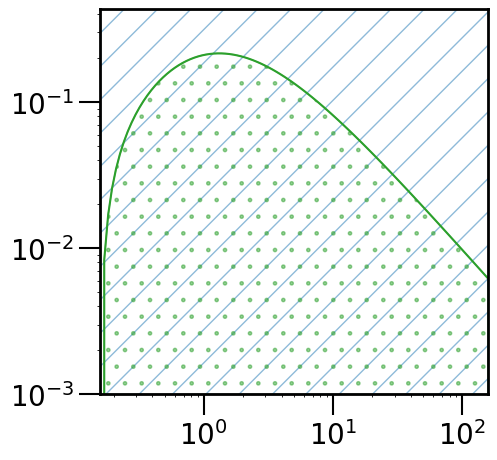

In [17]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.3], lgdFontSize=15, lgdHandleL=1.2, lgdFrameAlpha=0.5,
    lgdTitle='DNA+targ', lgdTtlFontSize=15,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=2
)

gammaChiN = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()
chiN = np.unique(parms['CN0']*parms['KPN'])
chiS = np.unique(parms['CN0']*parms['KPN'])

xmin = min(gammaChiN)
xmax = max(gammaChiN)
chiCritic = findCriticalXPS(parms)
ymin = 1e-3
ymax = max(chiCritic)*2

plt.fill_between(
    gammaChiN, ymin, ymax, label='DNA+clusTarg',
    facecolor='none', edgecolor='tab:blue', hatch='/', alpha=0.5
)
plt.fill_between(
    gammaChiN, ymin, chiCritic, label='DNA+targ',
    facecolor='none', edgecolor='tab:green', hatch='.', alpha=0.5
)

# fillY = np.linspace(0,max(chiCritic)*1.01,100)

# plt.axhline(chiS, ls=(0, (2, 2)), color='tab:red', label='$\chi_S $')

plt.semilogx(gammaChiN, chiCritic, label='$\chi^* $', color='tab:green')

# plt.fill_betweenx(fillY, (chiN*G1.root)[0], xmin, color='tab:green', alpha=0.2)
# plt.fill_betweenx(fillY, xmax, (chiN*G2.root)[0], color='tab:green', alpha=0.2)

# plt.fill_betweenx(fillY, (chiN*G1.root)[0], (chiN*G2.root)[0], color='tab:pink', alpha=0.2)

plt.loglog()
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.yticks([0,0.05,0.1,0.15,0.2],**tickfont)
# plt.xlabel('$\gamma \chi_N$', **labelfont)
# plt.ylabel('$\chi_S$', **labelfont)
# plt.legend(**legend)

plt.show()

# protein bound ratio

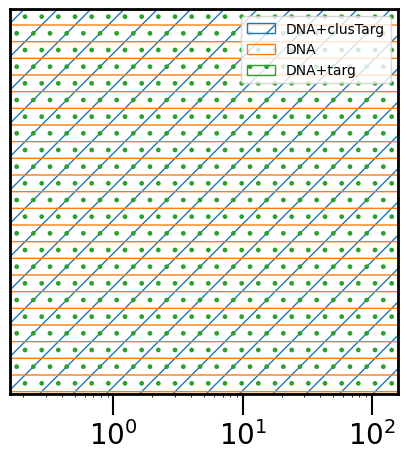

In [198]:
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.3], lgdFontSize=15, lgdFrameAlpha=0.5,
    lgdTitle='DNA+targ', lgdTtlFontSize=15,
    labelFontSize=20, tickFontSize=20, 
    tickL=15, tickW=1.5, spineLineW=2
)

gammaChiN = parms['gamma'].to_numpy()*parms['CN0'].to_numpy()*parms['KPN'].to_numpy()

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+clusTarg',
    facecolor='none', edgecolor='tab:blue', hatch='/', alpha=1.0
)
plt.fill_between(
    gammaChiN, 0, 1, label='DNA', 
    facecolor='none', edgecolor='tab:orange', hatch='-', alpha=1.0,
)
plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ',
    facecolor='none', edgecolor='tab:green', hatch='.', alpha=1.0
)

plt.semilogx()
plt.xlim([min(gammaChiN),max(gammaChiN)])
plt.ylim([0,1])
plt.xticks(**tickfont)
plt.yticks([],)

plt.legend()

plt.show()

([], [])

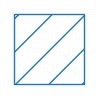

In [206]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+clusTarg',
    facecolor='none', edgecolor='tab:blue', hatch='/', alpha=1.0
)

plt.xticks([])
plt.yticks([])




([], [])

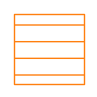

In [207]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA', 
    facecolor='none', edgecolor='tab:orange', hatch='-', alpha=1.0,
)

plt.xticks([])
plt.yticks([])




([], [])

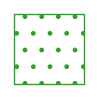

In [208]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ',
    facecolor='none', edgecolor='tab:green', hatch='.', alpha=1.0
)

plt.xticks([])
plt.yticks([])


([], [])

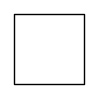

In [209]:
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(111)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0)  # change width

plt.fill_between(
    gammaChiN, 0, 1, label='DNA+targ',
    facecolor='none', 
)

plt.xticks([])
plt.yticks([])
